In [1]:
import ee

# connect to google account
#ee.Authenticate()
ee.Initialize()

In [2]:
## determine study area and subsets
# define region of interest
studyArea = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -98.85498046875,
              81.00088931051033
            ],
            [
              -87.978515625,
              81.00088931051033
            ],
            [
              -87.978515625,
              82.26761366413521
            ],
            [
              -98.85498046875,
              82.26761366413521
            ],
            [
              -98.85498046875,
              81.00088931051033
            ]
          ]
        ]
      }
    }
  ]
}

seaIce = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
                [
                  [
                    -94.745799,
                    81.411421
                  ],
                  [
                    -96.558775,
                    81.270834
                  ],
                  [
                    -97.668536,
                    81.080394
                  ],
                  [
                    -98.822247,
                    81.340584
                  ],
                  [
                    -96.888407,
                    81.59324
                  ],
                  [
                    -95.383088,
                    81.723929
                  ],
                  [
                    -93.877769,
                    81.833895
                  ],
                  [
                    -93.207517,
                    81.679532
                  ],
                  [
                    -93.262456,
                    81.578772
                  ],
                  [
                    -94.086536,
                    81.502813
                  ],
                  [
                    -94.416168,
                    81.577163
                  ],
                  [
                    -95.020493,
                    81.496317
                  ],
                  [
                    -94.745799,
                    81.411421
                  ]
                ]
              ]
      }
    }
  ]
}

openWater = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
                [
                  [
                    -89.288519,
                    81.010966
                  ],
                  [
                    -89.299507,
                    80.942043
                  ],
                  [
                    -88.621015,
                    80.989054
                  ],
                  [
                    -88.033171,
                    81.010966
                  ],
                  [
                    -87.700792,
                    80.995934
                  ],
                  [
                    -87.376654,
                    80.981738
                  ],
                  [
                    -87.008565,
                    81.000661
                  ],
                  [
                    -86.525105,
                    81.017401
                  ],
                  [
                    -86.327326,
                    81.057195
                  ],
                  [
                    -86.678933,
                    81.090436
                  ],
                  [
                    -86.750354,
                    81.054633
                  ],
                  [
                    -86.934398,
                    81.05207
                  ],
                  [
                    -87.074492,
                    81.078092
                  ],
                  [
                    -87.456315,
                    81.056341
                  ],
                  [
                    -87.791441,
                    81.052498
                  ],
                  [
                    -88.085363,
                    81.063171
                  ],
                  [
                    -88.560582,
                    81.048225
                  ],
                  [
                    -88.978116,
                    81.027687
                  ],
                  [
                    -89.288519,
                    81.010966
                  ]
                ]
              ]
      }
    }
  ]
}

In [3]:
from datetime import datetime, timedelta

## select desired image
def createImage(geoJSON, date, polarisation, orbitNumber,orbitPass, clip):
    # set area of interest
    coords = geoJSON['features'][0]['geometry']['coordinates']
    aoi = ee.Geometry.Polygon(coords)
    
    # set date range
    
    start_date = date
    end_date = str(datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days=1)).split(' ')[0]
    
    # pull boundary
    if clip:
        ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD')
                               .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarisation))
                               .filter(ee.Filter.eq('relativeOrbitNumber_start', orbitNumber))
                               .filter(ee.Filter.eq('orbitProperties_pass', orbitPass))
                               .filter(ee.Filter.eq('instrumentMode', 'IW'))
                               .filterBounds(aoi) 
                               .filterDate(ee.Date(start_date), ee.Date(end_date)) 
                               .first()
                               .clip(aoi)
                         )
    else:
        ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD')
                               .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarisation))
                               .filter(ee.Filter.eq('relativeOrbitNumber_start', orbitNumber))
                               .filter(ee.Filter.eq('orbitProperties_pass', orbitPass))
                               .filter(ee.Filter.eq('instrumentMode', 'IW'))
                               .filterBounds(aoi) 
                               .filterDate(ee.Date(start_date), ee.Date(end_date)) 
                               .first()
                         )
    ## create map
    location = aoi.centroid().coordinates().getInfo()[::-1]

    # select image
    return ee.Image(ffa_db.select(polarisation))

In [4]:
import geemap

## create map
# set center point and basemap
Map = geemap.Map(center=(75, -100), zoom=4)
Map.add_basemap('HYBRID')

# add layers
vis_params = {'min': -20, 'max': 0}

## add map layers
# study area
Map.addLayer(
    createImage(studyArea, '2021-01-26', 'HH', 18, 'ASCENDING', False),
    vis_params,
    "sa_2021-01-26_HH_D")

Map.addLayer(
    createImage(seaIce, '2021-01-26', 'HH', 18, 'ASCENDING', True),
    vis_params,
    "si_2021-01-26_HH_D")

Map.addLayer(
    createImage(openWater, '2021-01-26', 'HH', 18, 'ASCENDING', True),
    vis_params,
    "ow_2021-01-26_HH_D")

# display map
Map

Map(center=[75, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

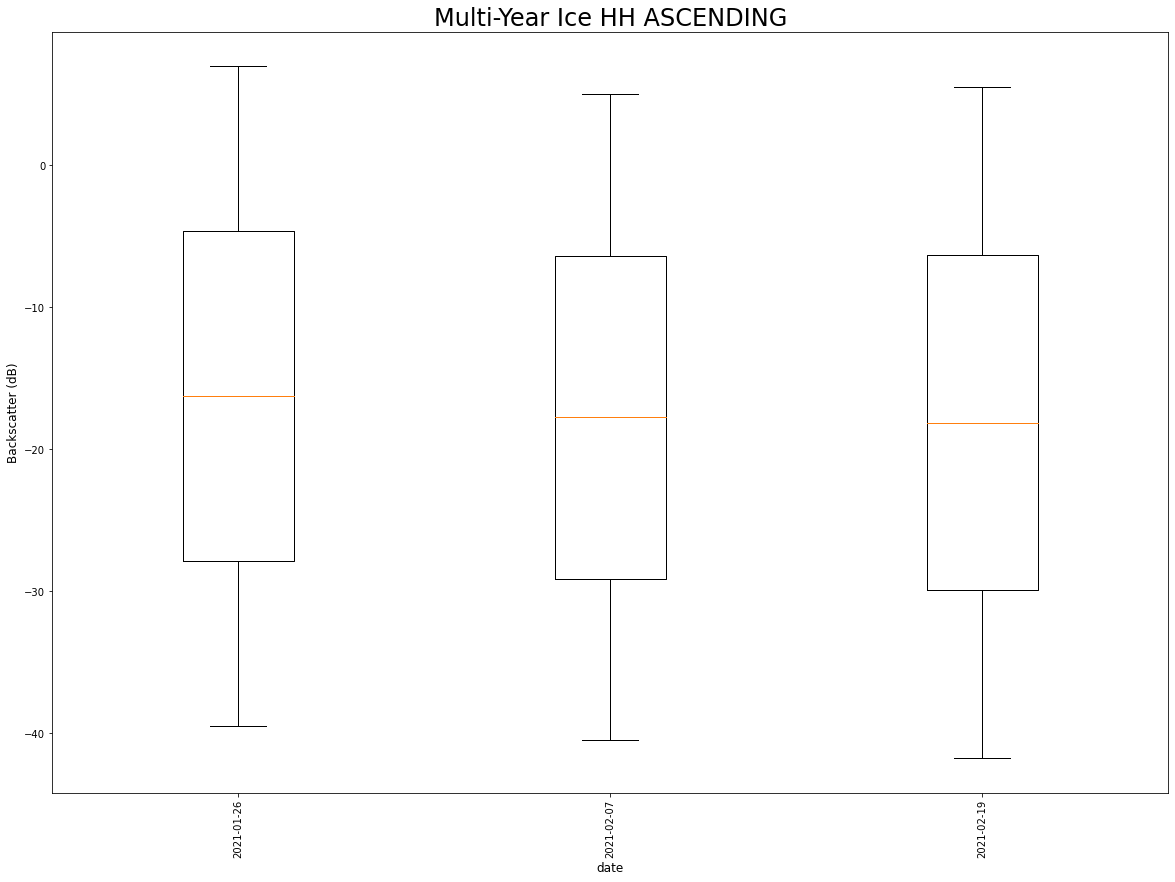

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

dates = [
    '2021-01-26',
    '2021-02-07',
    '2021-02-19'
]

def createBoxPlot(classification, geoJSON, dates, polarisation, orbitNumber,orbitPass, clip):
    
    x = []
    valid_dates = []
    df = pd.DataFrame(columns=['Classification',
                               'Date',
                               'Polarisation',
                               'Orbit Pass',
                               'Mean',
                               'Variance',
                               'Median',
                               'Standard Deviation',
                               'Mode',
                               'Max',
                               'Min'
                              ])
    mean = 0
    variance = 0
    covariance = 0
    median = 0
    st_dev = 0
    mode = 0
    max_ = 0
    min_ = 0
    for date in dates:
        try:
            # create data
            data = createImage(geoJSON, date, polarisation, orbitNumber,orbitPass, clip)
            hist = data.select(polarisation).reduceRegion(
                ee.Reducer.autoHistogram(), bestEffort=True
            ).get(polarisation).getInfo()
            
            # determine summary statistics
            mean = data.select(polarisation).reduceRegion(
                ee.Reducer.mean(), bestEffort=True
            ).get(polarisation).getInfo()
            variance = data.select(polarisation).reduceRegion(
                ee.Reducer.variance(), bestEffort=True
            ).get(polarisation).getInfo()
            median = data.select(polarisation).reduceRegion(
                ee.Reducer.median(), bestEffort=True
            ).get(polarisation).getInfo()
            std_dev = data.select(polarisation).reduceRegion(
                ee.Reducer.stdDev(), bestEffort=True
            ).get(polarisation).getInfo()
            mode = data.select(polarisation).reduceRegion(
                ee.Reducer.mode(), bestEffort=True
            ).get(polarisation).getInfo()
            max_ = data.select(polarisation).reduceRegion(
                ee.Reducer.max(), bestEffort=True
            ).get(polarisation).getInfo()
            min_ = data.select(polarisation).reduceRegion(
                ee.Reducer.min(), bestEffort=True
            ).get(polarisation).getInfo()
            
            summaryStats = {
                'Classification': [classification],
                'Date': [date],
                'Polarisation': [polarisation],
                'Orbit Pass': [orbitPass],
                'Mean': [mean],
                'Variance': [variance],
                'Median': [median],
                'Standard Deviation': [std_dev],
                'Mode': [mode],
                'Max': [max_],
                'Min': [min_]
            }
            summary = pd.DataFrame(summaryStats)
            df = df.append(summary, ignore_index = True)
            
            # prep data for box and whisker plots
            a = np.array(hist)
            x += [a[:, 0]]
            valid_dates += [date]
        except:
            pass
    filename = 'summary_%s_%s_%s.csv' % (classification, polarisation, orbitPass)
    df.to_csv(filename.replace(' ', '_'))
    fig = plt.figure(figsize =(20, 14))
    ax = fig.add_subplot(111)
    plt.boxplot(x)
    ax.set_xticklabels(valid_dates, rotation = 90)
    ax.set_title('%s %s %s' % (classification, polarisation, orbitPass), fontsize = 24)
    plt.xlabel('date', fontsize=12)
    plt.ylabel('Backscatter (dB)', fontsize=12)
    plt.show()

createBoxPlot('Multi-Year Ice', seaIce, dates, 'HH', 18, 'ASCENDING', True)

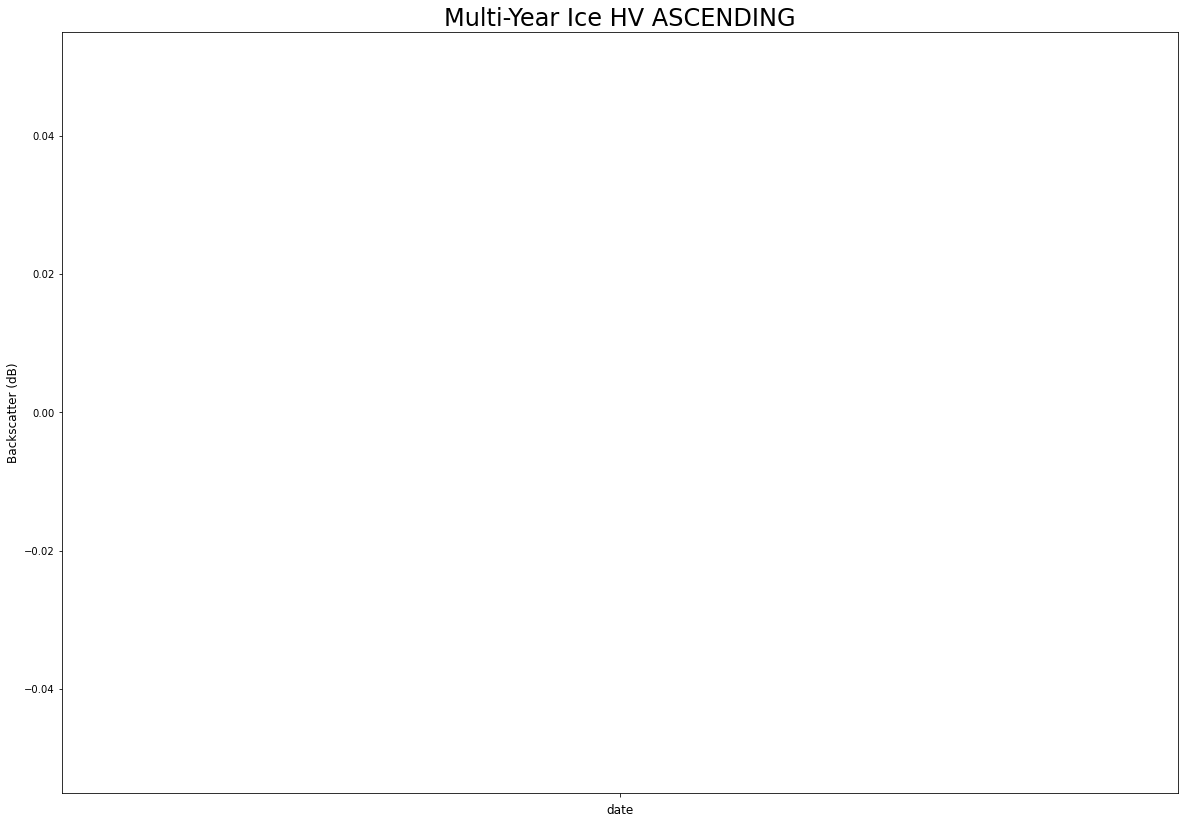

In [6]:
createBoxPlot('Multi-Year Ice', seaIce, dates, 'HV', 18, 'ASCENDING', True)

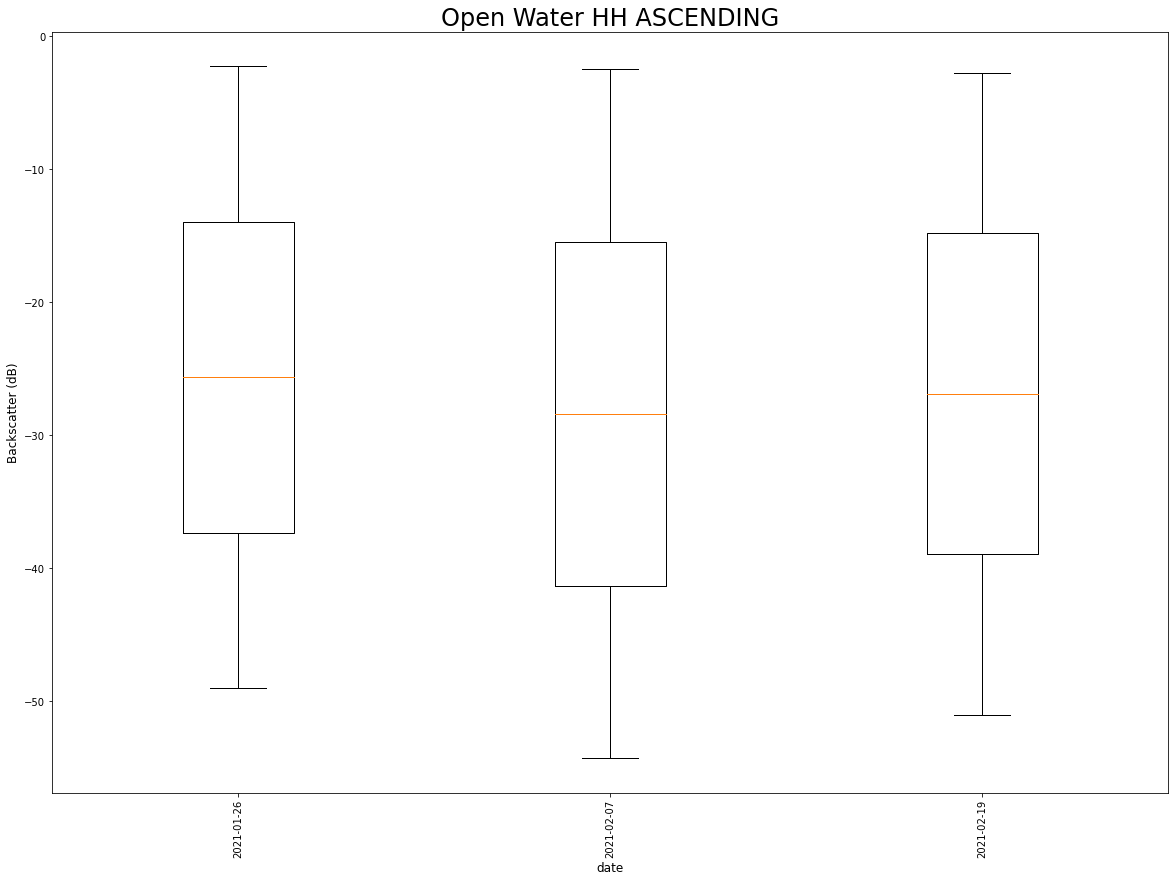

In [7]:
createBoxPlot('Open Water', openWater, dates, 'HH', 18, 'ASCENDING', True)

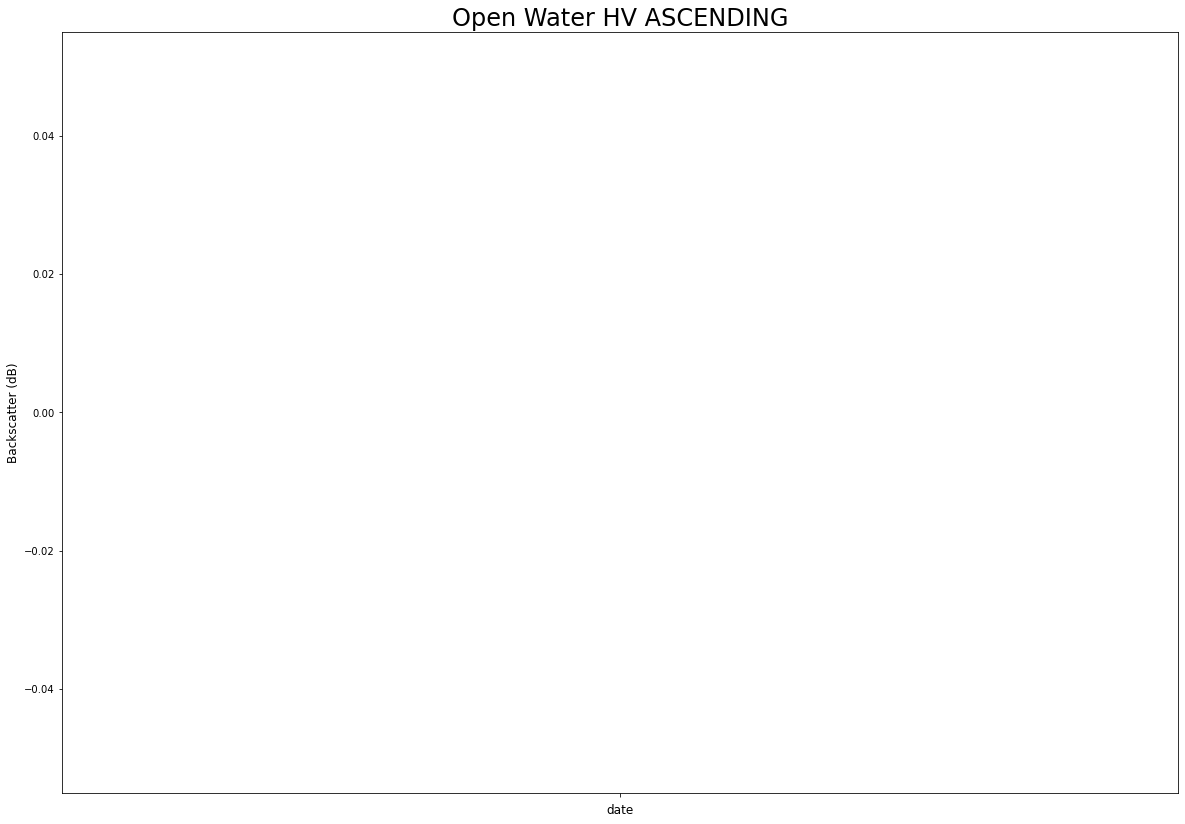

In [8]:
createBoxPlot('Open Water', openWater, dates, 'HV', 18, 'ASCENDING', True)